# Model Training & Cross-Validation Notebook


**Notebook:** 03_model_training.ipynb  
**Input:** data/processed/nwmp_cleaned_v1.csv / parquet  
**Output:** Cross-validated baseline model performance  


### Model Training & Evaluation

### Objective
Train and evaluate supervised classification models to predict water quality class
using a clean, leakage-free dataset. Emphasis is placed on robustness under class
imbalance using macro-averaged metrics and stratified cross-validation.


### Imports

In [1]:
import pandas as pd
import numpy as np

import os

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from xgboost import XGBClassifier

In [2]:
from utils.config import DATA_DIR
from src.data_preprocessing.create_dataframe import create_dataframe

### Data Loading

In [3]:
DATA_PATH = os.path.join(DATA_DIR, "processed", "csv", "nwmp_features_v1.csv")

df = create_dataframe(DATA_PATH)

print(f"✓ Loaded feature dataset: {df.shape}")

✓ Loaded feature dataset: (171, 180)


### Feature / Target Split

In [4]:
TARGET_COL = 'use_based_class'

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

print(f"✓ Split features and target: X={X.shape}, y={y.shape}")
print(y.value_counts(normalize=True))

✓ Split features and target: X=(171, 179), y=(171,)
use_based_class
A    0.824561
E    0.111111
C    0.035088
B    0.029240
Name: proportion, dtype: float64


### Encode target labels

In [5]:

label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(y)

### Train–Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

print(X_train.shape, X_test.shape)

(136, 179) (35, 179)


### Cross-validation

In [7]:
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

### Model Pipelines

#### Logistic Regression

In [8]:
log_reg_pipeline = Pipeline(steps=[
    ("scaler", RobustScaler()),
    ("model", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        random_state=42
    ))
])


#### Random Forest

In [9]:
rf_pipeline = Pipeline(steps=[
    ("scaler", RobustScaler()),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced"
    ))
])


#### XGBoost

In [10]:
xgb_pipeline = Pipeline(
    steps=[
        ("scaler", RobustScaler()),
        ("model", XGBClassifier(
            objective="multi:softprob",
            eval_metric="mlogloss",
            max_depth=4,
            learning_rate=0.1,
            n_estimators=300,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        ))
    ]
)


### Evaluation Metrics

In [11]:
scoring = {
    "accuracy": "accuracy",
    "f1_macro": "f1_macro",
    "precision_macro": "precision_macro",
    "recall_macro": "recall_macro"
}

### Cross-Validation Execution

In [12]:
models = {
    "LogisticRegression": log_reg_pipeline,
    "RandomForest": rf_pipeline,
    "XGBoost": xgb_pipeline
    }

In [13]:
cv_results = {}

for name, pipeline in models.items():
    print(f"Training and evaluating model: {name}")
    scores = cross_validate(
        pipeline,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring,
        n_jobs=-1
    )
    cv_results[name] = scores

Training and evaluating model: LogisticRegression


/Users/rex/Documents/personal/AquaSafe/.venv/lib/python3.13/site-packages/sklearn/model_selection/_split.py:813: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/rex/Documents/personal/AquaSafe/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rex/Documents/personal/AquaSafe/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rex/Documents/personal/AquaSafe/.venv/lib/python3.13/site-

Training and evaluating model: RandomForest


/Users/rex/Documents/personal/AquaSafe/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rex/Documents/personal/AquaSafe/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rex/Documents/personal/AquaSafe/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

Training and evaluating model: XGBoost


/Users/rex/Documents/personal/AquaSafe/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rex/Documents/personal/AquaSafe/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rex/Documents/personal/AquaSafe/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

In [14]:
# ============================================================================
# CROSS-VALIDATION RESULTS SUMMARY
# ============================================================================
print("\n" + "="*80)
print("📊 CROSS-VALIDATION RESULTS (Training Set Only)")
print("="*80)

for name, scores in cv_results.items():
    print(f"\n{name}:")
    print("-" * 40)
    for metric in scoring.keys():
        mean_score = np.mean(scores[f'test_{metric}'])
        std_score = np.std(scores[f'test_{metric}'])
        print(f"  {metric:.<25} {mean_score:.4f} ± {std_score:.4f}")


📊 CROSS-VALIDATION RESULTS (Training Set Only)

LogisticRegression:
----------------------------------------
  accuracy................. 0.9270 ± 0.0386
  f1_macro................. 0.7054 ± 0.0995
  precision_macro.......... 0.6774 ± 0.0968
  recall_macro............. 0.7716 ± 0.1107

RandomForest:
----------------------------------------
  accuracy................. 0.9188 ± 0.0435
  f1_macro................. 0.5737 ± 0.1576
  precision_macro.......... 0.6117 ± 0.1213
  recall_macro............. 0.5611 ± 0.1698

XGBoost:
----------------------------------------
  accuracy................. 0.9632 ± 0.0331
  f1_macro................. 0.7700 ± 0.2038
  precision_macro.......... 0.7686 ± 0.2049
  recall_macro............. 0.7833 ± 0.1944


---

## 🎯 Final Test Set Evaluation

**Objective:** Evaluate all models on the held-out test set for honest performance assessment

In [15]:
# ============================================================================
# FINAL MODEL TRAINING & TEST SET EVALUATION
# ============================================================================
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)

print("\n" + "="*80)
print("🎯 FINAL MODEL TRAINING & TEST SET EVALUATION")
print("="*80)

final_results = {}

for name, pipeline in models.items():
    print(f"\n{'='*80}")
    print(f"Training {name} on full training set...")
    print('='*80)
    
    # Train on full training set
    pipeline.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)
    
    # Calculate metrics
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_macro': f1_score(y_test, y_pred, average='macro', zero_division=0),
        'precision_macro': precision_score(y_test, y_pred, average='macro', zero_division=0),
        'recall_macro': recall_score(y_test, y_pred, average='macro', zero_division=0)
    }
    
    # Store results
    final_results[name] = {
        'pipeline': pipeline,
        'metrics': test_metrics,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(
            y_test, y_pred,
            target_names=label_encoder.classes_,
            output_dict=True,
            zero_division=0
        )
    }
    
    # Display test metrics
    print(f"\n{name} Test Set Performance:")
    print("-" * 40)
    for metric, value in test_metrics.items():
        print(f"  {metric:.<25} {value:.4f}")
    
    print("-" * 40)

print("\n" + "="*80)
print("✅ All models trained and evaluated on test set")
print("="*80)


🎯 FINAL MODEL TRAINING & TEST SET EVALUATION

Training LogisticRegression on full training set...

LogisticRegression Test Set Performance:
----------------------------------------
  accuracy................. 0.9714
  f1_macro................. 0.9600
  precision_macro.......... 0.9917
  recall_macro............. 0.9375
----------------------------------------

Training RandomForest on full training set...

RandomForest Test Set Performance:
----------------------------------------
  accuracy................. 0.9429
  f1_macro................. 0.9083
  precision_macro.......... 0.9839
  recall_macro............. 0.8750
----------------------------------------

Training XGBoost on full training set...

XGBoost Test Set Performance:
----------------------------------------
  accuracy................. 0.9714
  f1_macro................. 0.8810
  precision_macro.......... 0.8750
  recall_macro............. 0.9375
----------------------------------------

✅ All models trained and evaluated o

### 📊 Confusion Matrices

**Objective:** Visualize classification performance and identify misclassification patterns

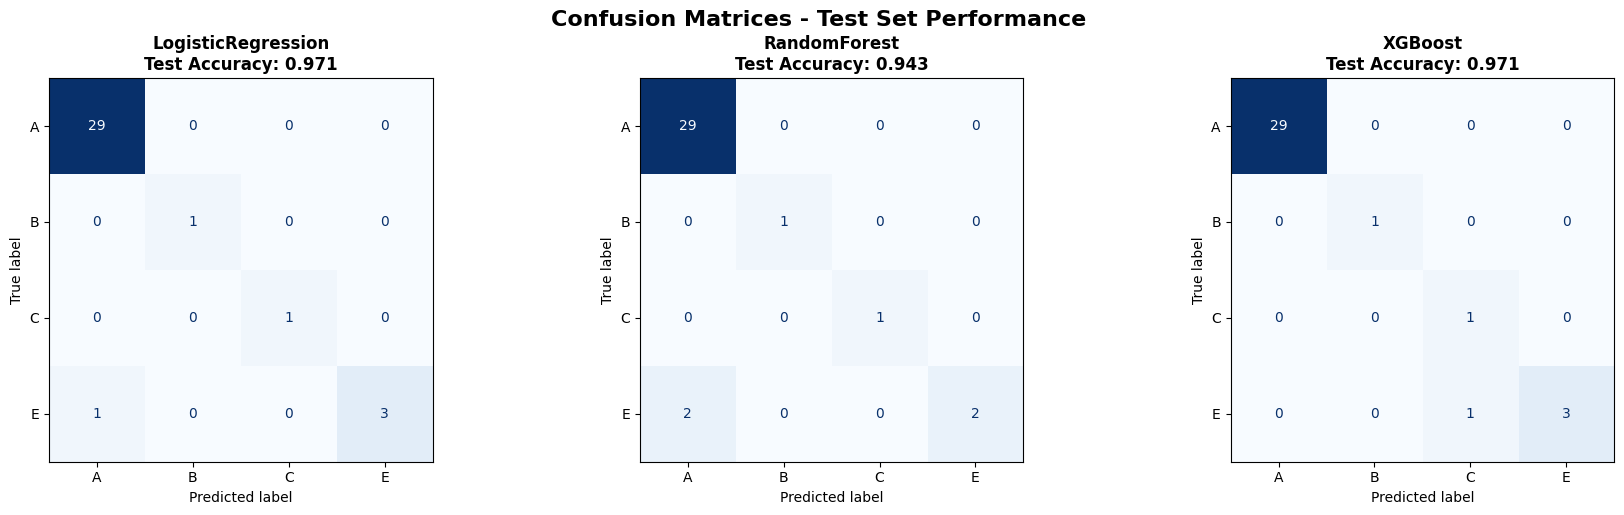


💡 Interpretation:
   Diagonal = Correct predictions
   Off-diagonal = Misclassifications


In [16]:
# ============================================================================
# VISUALIZATION 1: CONFUSION MATRICES (ALL MODELS)
# ============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, results) in enumerate(final_results.items()):
    cm = results['confusion_matrix']
    
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=label_encoder.classes_
    )
    disp.plot(ax=axes[idx], cmap='Blues', values_format='d', colorbar=False)
    axes[idx].set_title(f'{name}\nTest Accuracy: {results["metrics"]["accuracy"]:.3f}',
                       fontweight='bold', fontsize=12)
    axes[idx].grid(False)

plt.tight_layout()
plt.suptitle('Confusion Matrices - Test Set Performance',
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

print("\n💡 Interpretation:")
print("   Diagonal = Correct predictions")
print("   Off-diagonal = Misclassifications")

### 📈 Model Performance Comparison

**Objective:** Compare all models across metrics, identify best performer

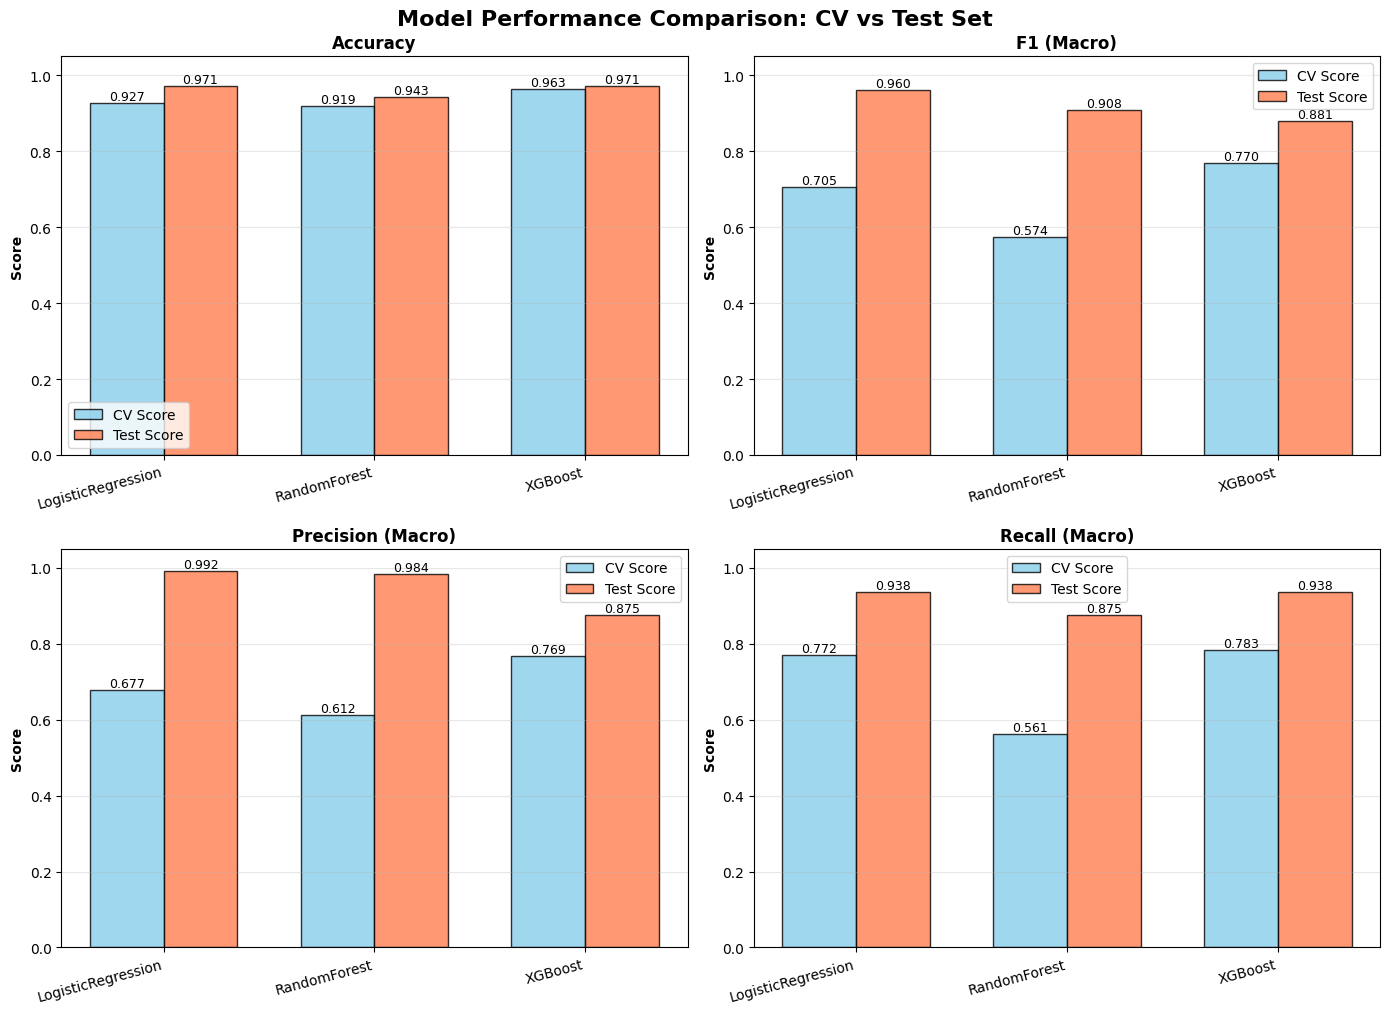

In [17]:
# ============================================================================
# VISUALIZATION 2: MODEL COMPARISON (CV vs TEST)
# ============================================================================
import pandas as pd

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

metrics = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']
metric_labels = ['Accuracy', 'F1 (Macro)', 'Precision (Macro)', 'Recall (Macro)']

for idx, (metric, label) in enumerate(zip(metrics, metric_labels)):
    model_names = list(models.keys())
    x = np.arange(len(model_names))
    width = 0.35
    
    # CV scores (mean)
    cv_scores = [np.mean(cv_results[name][f'test_{metric}']) for name in model_names]
    
    # Test scores
    test_scores = [final_results[name]['metrics'][metric] for name in model_names]
    
    bars1 = axes[idx].bar(x - width/2, cv_scores, width,
                          label='CV Score', color='skyblue', alpha=0.8, edgecolor='black')
    bars2 = axes[idx].bar(x + width/2, test_scores, width,
                          label='Test Score', color='coral', alpha=0.8, edgecolor='black')
    
    axes[idx].set_ylabel('Score', fontweight='bold')
    axes[idx].set_title(label, fontweight='bold', fontsize=12)
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(model_names, rotation=15, ha='right')
    axes[idx].legend()
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].set_ylim(0, 1.05)
    
    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                      f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    for bar in bars2:
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                      f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.suptitle('Model Performance Comparison: CV vs Test Set',
             fontsize=16, fontweight='bold', y=1.01)
plt.show()

### 📋 Detailed Classification Reports

**Objective:** Analyze per-class performance for each model

In [18]:
# ============================================================================
# DETAILED CLASSIFICATION REPORTS (TEST SET)
# ============================================================================
print("\n" + "="*80)
print("📋 DETAILED CLASSIFICATION REPORTS - TEST SET")
print("="*80)

for name, results in final_results.items():
    print(f"\n{'='*80}")
    print(f"{name}")
    print('='*80)
    print(classification_report(
        y_test,
        results['y_pred'],
        target_names=label_encoder.classes_,
        digits=4,
        zero_division=0
    ))


📋 DETAILED CLASSIFICATION REPORTS - TEST SET

LogisticRegression
              precision    recall  f1-score   support

           A     0.9667    1.0000    0.9831        29
           B     1.0000    1.0000    1.0000         1
           C     1.0000    1.0000    1.0000         1
           E     1.0000    0.7500    0.8571         4

    accuracy                         0.9714        35
   macro avg     0.9917    0.9375    0.9600        35
weighted avg     0.9724    0.9714    0.9696        35


RandomForest
              precision    recall  f1-score   support

           A     0.9355    1.0000    0.9667        29
           B     1.0000    1.0000    1.0000         1
           C     1.0000    1.0000    1.0000         1
           E     1.0000    0.5000    0.6667         4

    accuracy                         0.9429        35
   macro avg     0.9839    0.8750    0.9083        35
weighted avg     0.9465    0.9429    0.9343        35


XGBoost
              precision    recall  f1-sco


🏆 Best Model: LogisticRegression
   Test F1 (Macro): 0.9600


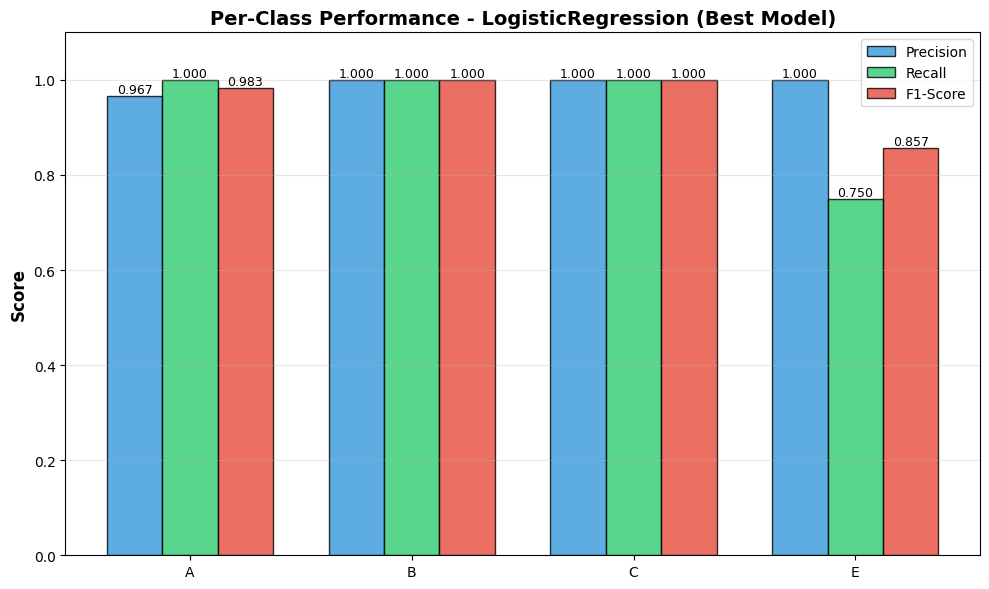


📊 Per-Class Analysis:
   Class A: F1=0.983 ✓ Good
   Class B: F1=1.000 ✓ Good
   Class C: F1=1.000 ✓ Good
   Class E: F1=0.857 ✓ Good


In [19]:
# ============================================================================
# VISUALIZATION 3: PER-CLASS PERFORMANCE (BEST MODEL)
# ============================================================================

# Find best model based on test F1 macro
best_model_name = max(final_results.keys(),
                      key=lambda x: final_results[x]['metrics']['f1_macro'])
best_model_report = final_results[best_model_name]['classification_report']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Test F1 (Macro): {final_results[best_model_name]['metrics']['f1_macro']:.4f}")

# Extract per-class metrics
classes = label_encoder.classes_
metrics_per_class = {
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

for cls in classes:
    if cls in best_model_report:
        metrics_per_class['Precision'].append(best_model_report[cls]['precision'])
        metrics_per_class['Recall'].append(best_model_report[cls]['recall'])
        metrics_per_class['F1-Score'].append(best_model_report[cls]['f1-score'])

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(classes))
width = 0.25

bars1 = ax.bar(x - width, metrics_per_class['Precision'], width,
               label='Precision', color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x, metrics_per_class['Recall'], width,
               label='Recall', color='#2ecc71', alpha=0.8, edgecolor='black')
bars3 = ax.bar(x + width, metrics_per_class['F1-Score'], width,
               label='F1-Score', color='#e74c3c', alpha=0.8, edgecolor='black')

ax.set_ylabel('Score', fontweight='bold', fontsize=12)
ax.set_title(f'Per-Class Performance - {best_model_name} (Best Model)',
             fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.1)

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Identify weak classes
print("\n📊 Per-Class Analysis:")
for cls, f1 in zip(classes, metrics_per_class['F1-Score']):
    status = "✓ Good" if f1 > 0.7 else "⚠️ Weak" if f1 > 0.5 else "❌ Poor"
    print(f"   Class {cls}: F1={f1:.3f} {status}")

### 🔍 Feature Importance Analysis

**Objective:** Identify most influential features (for tree-based models)


📊 Extracting feature importance from RandomForest...


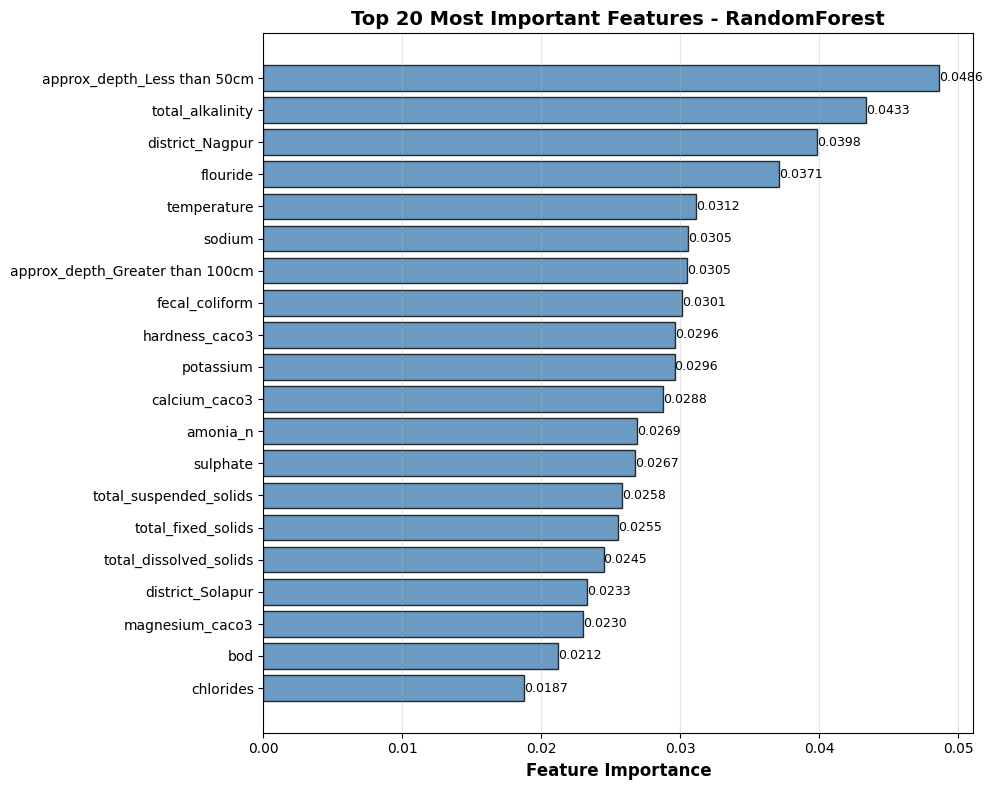


🔍 Top 10 Most Important Features (RandomForest):
                        Feature  Importance
    approx_depth_Less than 50cm    0.048641
               total_alkalinity    0.043348
                district_Nagpur    0.039837
                       flouride    0.037129
                    temperature    0.031160
                         sodium    0.030542
approx_depth_Greater than 100cm    0.030487
                 fecal_coliform    0.030095
                 hardness_caco3    0.029645
                      potassium    0.029584

📊 Extracting feature importance from XGBoost...


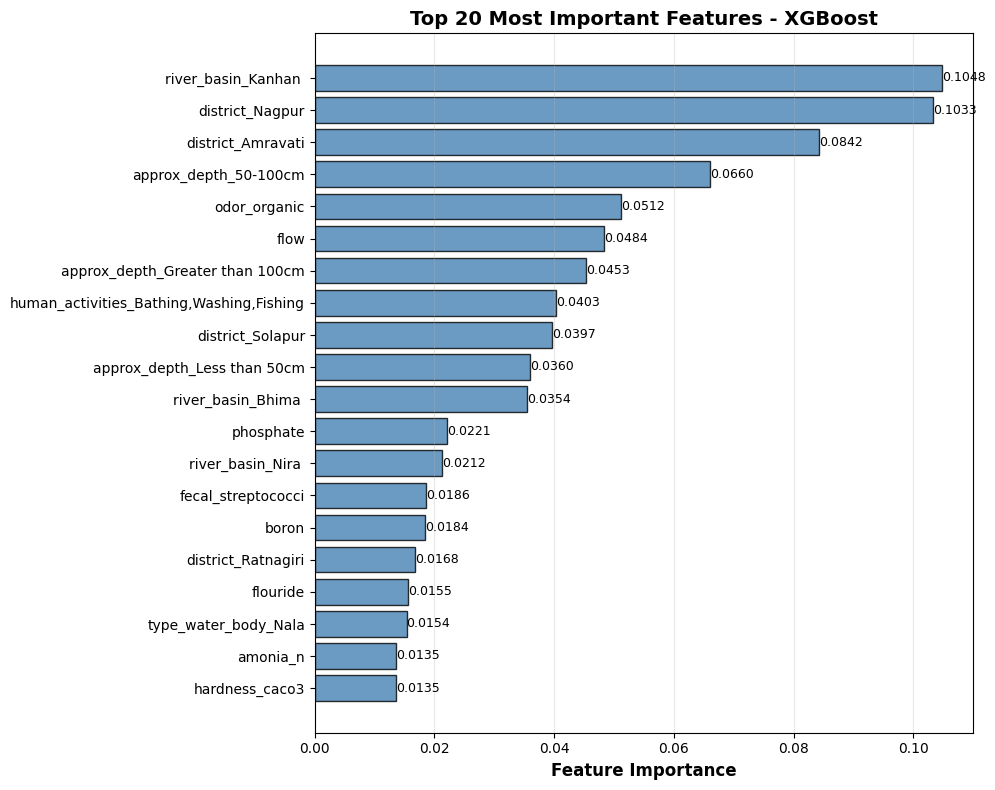


🔍 Top 10 Most Important Features (XGBoost):
                                 Feature  Importance
                     river_basin_Kanhan     0.104763
                         district_Nagpur    0.103329
                       district_Amravati    0.084233
                   approx_depth_50-100cm    0.066005
                            odor_organic    0.051180
                                    flow    0.048350
         approx_depth_Greater than 100cm    0.045312
human_activities_Bathing,Washing,Fishing    0.040316
                        district_Solapur    0.039711
             approx_depth_Less than 50cm    0.036007


In [20]:
# ============================================================================
# VISUALIZATION 4: FEATURE IMPORTANCE (TREE-BASED MODELS)
# ============================================================================

tree_models = ['RandomForest', 'XGBoost']

for name in tree_models:
    if name in final_results:
        print(f"\n📊 Extracting feature importance from {name}...")
        
        # Get the trained model from pipeline
        trained_model = final_results[name]['pipeline'].named_steps['model']
        
        # Get feature importance
        importances = trained_model.feature_importances_
        feature_names = X.columns
        
        # Create dataframe and sort
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
        
        # Plot top 20
        fig, ax = plt.subplots(figsize=(10, 8))
        
        top_n = min(20, len(importance_df))
        top_features = importance_df.head(top_n)
        
        bars = ax.barh(range(top_n), top_features['Importance'].values,
                       color='steelblue', alpha=0.8, edgecolor='black')
        ax.set_yticks(range(top_n))
        ax.set_yticklabels(top_features['Feature'].values)
        ax.invert_yaxis()
        ax.set_xlabel('Feature Importance', fontweight='bold', fontsize=12)
        ax.set_title(f'Top {top_n} Most Important Features - {name}',
                     fontweight='bold', fontsize=14)
        ax.grid(axis='x', alpha=0.3)
        
        # Add value labels
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2.,
                   f'{width:.4f}', ha='left', va='center', fontsize=9)
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n🔍 Top 10 Most Important Features ({name}):")
        print(importance_df.head(10).to_string(index=False))

---

## 💾 Model Persistence

**Objective:** Save trained models for deployment in Streamlit application

In [27]:
# ============================================================================
# MODEL PERSISTENCE - SAVE FOR STREAMLIT APP
# ============================================================================
import joblib
from pathlib import Path

# Create models directory
MODELS_DIR = Path(DATA_DIR).parent / "models"
MODELS_DIR.mkdir(exist_ok=True)

print("\n💾 Saving trained models for deployment...")
print("="*80)

# Save each trained model
for name, results in final_results.items():
    model_path = MODELS_DIR / f"{name.lower()}_pipeline.pkl"
    joblib.dump(results['pipeline'], model_path)
    file_size = os.path.getsize(model_path) / 1024  # KB
    print(f"  ✓ Saved: {model_path.name} ({file_size:.1f} KB)")

# Save label encoder
encoder_path = MODELS_DIR / "label_encoder.pkl"
joblib.dump(label_encoder, encoder_path)
print(f"  ✓ Saved: {encoder_path.name}")

# Save feature names
feature_names_path = MODELS_DIR / "feature_names.pkl"
joblib.dump(X.columns.tolist(), feature_names_path)
print(f"  ✓ Saved: {feature_names_path.name}")

# Save best model name
best_model_path = MODELS_DIR / "best_model_name.txt"
with open(best_model_path, 'w') as f:
    f.write(best_model_name)
print(f"  ✓ Saved: {best_model_path.name} (contains: '{best_model_name}')")

print("\n" + "="*80)
print(f"✅ All models saved to: {MODELS_DIR}")
print(f"   Total files: {len(list(MODELS_DIR.glob('*.pkl')))} .pkl files")
print("="*80)

# Test loading
print("\n🔍 Testing model loading...")
try:
    loaded_model = joblib.load(MODELS_DIR / f"{best_model_name.lower()}_pipeline.pkl")
    test_pred = loaded_model.predict(X_test[:10])
    print(f"  ✓ Successfully loaded and tested {best_model_name}")
    print(f"    Sample predictions: {label_encoder.inverse_transform(test_pred)}")
except Exception as e:
    print(f"  ❌ Error loading model: {e}")


💾 Saving trained models for deployment...
  ✓ Saved: logisticregression_pipeline.pkl (13.8 KB)
  ✓ Saved: randomforest_pipeline.pkl (1174.7 KB)
  ✓ Saved: xgboost_pipeline.pkl (888.5 KB)
  ✓ Saved: label_encoder.pkl
  ✓ Saved: feature_names.pkl
  ✓ Saved: best_model_name.txt (contains: 'LogisticRegression')

✅ All models saved to: /Users/rex/Documents/personal/AquaSafe/models
   Total files: 5 .pkl files

🔍 Testing model loading...
  ✓ Successfully loaded and tested LogisticRegression
    Sample predictions: ['A' 'A' 'A' 'A' 'A' 'E' 'A' 'A' 'A' 'A']


### 📊 Final Model Comparison Summary

**Objective:** Consolidated view of all model performance metrics

In [22]:
# ============================================================================
# COMPREHENSIVE MODEL COMPARISON SUMMARY
# ============================================================================
print("\n" + "="*80)
print("📊 COMPREHENSIVE MODEL COMPARISON SUMMARY")
print("="*80)

summary_rows = []
for name in models.keys():
    cv_scores = cv_results[name]
    test_scores = final_results[name]['metrics']
    
    # Calculate overfitting gap
    cv_f1 = np.mean(cv_scores['test_f1_macro'])
    test_f1 = test_scores['f1_macro']
    gap = cv_f1 - test_f1
    
    summary_rows.append({
        'Model': name,
        'CV Accuracy': f"{np.mean(cv_scores['test_accuracy']):.4f} ± {np.std(cv_scores['test_accuracy']):.4f}",
        'Test Accuracy': f"{test_scores['accuracy']:.4f}",
        'CV F1 (Macro)': f"{cv_f1:.4f} ± {np.std(cv_scores['test_f1_macro']):.4f}",
        'Test F1 (Macro)': f"{test_f1:.4f}",
        'Overfitting Gap': f"{gap:+.4f}"
    })

summary_df = pd.DataFrame(summary_rows)
print("\n" + summary_df.to_string(index=False))
print("\n" + "="*80)

# Identify best model
best_idx = summary_df['Test F1 (Macro)'].apply(lambda x: float(x)).argmax()
print(f"\n🏆 BEST MODEL: {summary_df.iloc[best_idx]['Model']}")
print(f"   Test F1 (Macro): {summary_df.iloc[best_idx]['Test F1 (Macro)']}")
print(f"   Reason: Highest test F1 score (best balance across all classes)")

# Check for overfitting
for idx, row in summary_df.iterrows():
    gap = float(row['Overfitting Gap'])
    if gap > 0.1:
        print(f"\n⚠️ {row['Model']}: Large overfitting gap ({gap:+.4f})")
        print(f"   CV performance significantly better than test")
    elif gap < -0.05:
        print(f"\n⚠️ {row['Model']}: Underfitting suspected ({gap:+.4f})")
        print(f"   Test performance better than CV (unusual)")

print("\n" + "="*80)


📊 COMPREHENSIVE MODEL COMPARISON SUMMARY

             Model     CV Accuracy Test Accuracy   CV F1 (Macro) Test F1 (Macro) Overfitting Gap
LogisticRegression 0.9270 ± 0.0386        0.9714 0.7054 ± 0.0995          0.9600         -0.2547
      RandomForest 0.9188 ± 0.0435        0.9429 0.5737 ± 0.1576          0.9083         -0.3347
           XGBoost 0.9632 ± 0.0331        0.9714 0.7700 ± 0.2038          0.8810         -0.1109


🏆 BEST MODEL: LogisticRegression
   Test F1 (Macro): 0.9600
   Reason: Highest test F1 score (best balance across all classes)

⚠️ LogisticRegression: Underfitting suspected (-0.2547)
   Test performance better than CV (unusual)

⚠️ RandomForest: Underfitting suspected (-0.3347)
   Test performance better than CV (unusual)

⚠️ XGBoost: Underfitting suspected (-0.1109)
   Test performance better than CV (unusual)

